In [190]:
import pandas as pd
import tensorflow as tf
import numpy as np
import ast
import tensorflow_hub as hub

In [191]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [192]:
train_df['category'] = train_df['category'].apply(ast.literal_eval)
test_df['category'] = test_df['category'].apply(ast.literal_eval)

In [193]:
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

# Convert TensorFlow tensors to numpy arrays
train_categories_array = train_categories_tensor.numpy()
test_categories_array = test_categories_tensor.numpy()

# Convert numpy arrays to sets of tuples
train_categories = set(tuple(x) for x in train_categories_array)
test_categories = set(tuple(x) for x in test_categories_array)

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


In [194]:
import tensorflow as tf

categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return [vocab[index] for index in hot_indices]

# Save your category labels to a file
with open('categories.txt', 'w') as f:
    for category in vocab:  # 'vocab' is your list of unique category labels
        f.write(f"{category}\n")

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


In [195]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Mobility (transport)', 'Future of work']
Label-binarized representation: [[0. 0. 0. 0. 1. 1.]]


In [196]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()

count    288.000000
mean      13.864583
std       24.931664
min        1.000000
25%        5.000000
50%        8.000000
75%       13.000000
max      179.000000
Name: Sentence, dtype: float64

In [197]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_seqlen = 20
batch_size = 1
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [198]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

1071


In [199]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [200]:
import numpy as np
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

[0. 1. 0. 0. 0. 0.]
Abstract: b'"Do you have any ideas?"'
Label(s): ['other']
 


In [201]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [202]:

# Extract texts and labels from the dataset

train_texts = [text.numpy()[0].decode('utf-8') for text, label in train_dataset]
train_labels = [label.numpy() for text, label in train_dataset]

test_texts = [text.numpy()[0].decode('utf-8') for text, label in test_dataset]
test_labels = [label.numpy() for text, label in test_dataset]



# Compute embeddings
train_embeddings = sbert_model.encode(train_texts)
test_embeddings = sbert_model.encode(test_texts)

In [203]:
# Define a function to convert lists of arrays into tensors
def arrays_to_tensors(embeddings, labels):
    embeddings_tensor = tf.convert_to_tensor(embeddings)
    labels_tensor = tf.convert_to_tensor(labels)
    dataset = tf.data.Dataset.from_tensor_slices((embeddings_tensor, labels_tensor))
    return dataset

# Convert lists of arrays into tensors
train_dataset = arrays_to_tensors(train_embeddings, train_labels)
test_dataset = arrays_to_tensors(test_embeddings, test_labels)

train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [204]:
from tensorflow.python.keras import metrics
from tensorflow.keras import layers

def make_model():
    mlp_model = tf.keras.Sequential(
        [
            layers.Dense(768, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(lookup.vocabulary_size()),
            layers.Reshape((1, -1)),  # Add this line to reshape output
            layers.Activation("sigmoid"),
        ]
    )
    return mlp_model

class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [205]:
# from collections import Counter
# from itertools import chain
#
# # Flatten the list of categories and count the occurrences
# class_counts = dict(Counter(chain(*train_df['category'])))
#
# # Calculate total number of samples
# total_samples = len(train_df)
#
# # Calculate class weights
# class_weights = {cls: 1 / count for cls, count in class_counts.items()}
#
# # Convert class_weights to tensor format
# class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())])
#
# # Define weighted loss function
# def weighted_binary_crossentropy(y_true, y_pred):
#     return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, class_weights_tensor)

In [206]:
# print(class_weights)

In [226]:
epochs = 200

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

In [227]:
history = shallow_mlp_model.fit(
    train_dataset,
    epochs=epochs,
)

Epoch 1/200
9/9 [==============================] - 2s 22ms/step - loss: 0.6581 - binary_accuracy: 0.6464 - precision: 0.2134 - recall: 0.4212 - f1_score: 0.2814
Epoch 2/200
9/9 [==============================] - 0s 22ms/step - loss: 0.5811 - binary_accuracy: 0.7448 - precision: 0.2363 - recall: 0.3084 - f1_score: 0.2673
Epoch 3/200
9/9 [==============================] - 0s 22ms/step - loss: 0.5523 - binary_accuracy: 0.7448 - precision: 0.2556 - recall: 0.2907 - f1_score: 0.2720
Epoch 4/200
9/9 [==============================] - 0s 21ms/step - loss: 0.5311 - binary_accuracy: 0.7448 - precision: 0.2658 - recall: 0.2832 - f1_score: 0.2742
Epoch 5/200
9/9 [==============================] - 0s 20ms/step - loss: 0.5162 - binary_accuracy: 0.7448 - precision: 0.2720 - recall: 0.2791 - f1_score: 0.2755
Epoch 6/200
9/9 [==============================] - 0s 18ms/step - loss: 0.4965 - binary_accuracy: 0.7448 - precision: 0.2763 - recall: 0.2765 - f1_score: 0.2764
Epoch 7/200
9/9 [=================

In [237]:
# Save the model
shallow_mlp_model.save('BERT_20230606.h5')

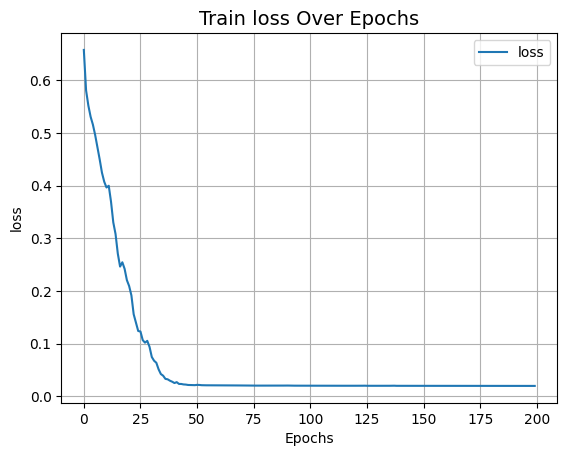

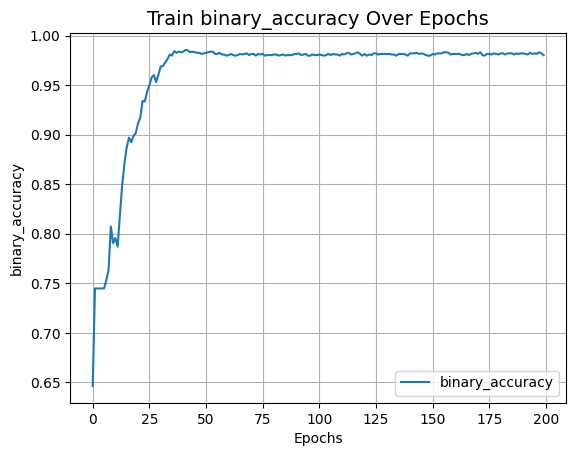

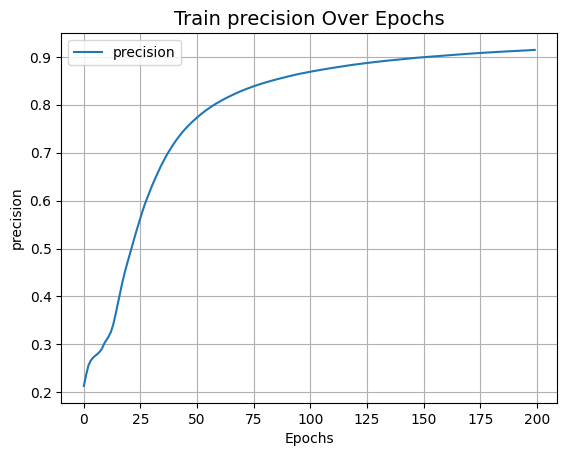

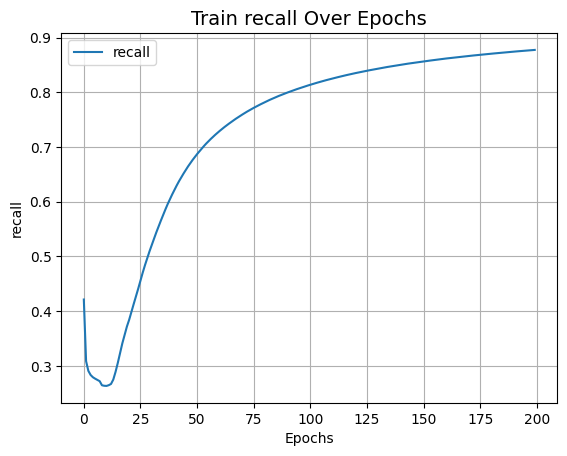

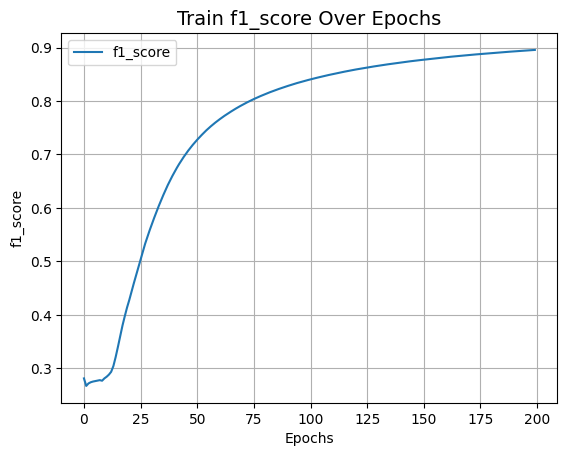

In [228]:
import matplotlib.pyplot as plt
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("binary_accuracy")
plot_result("precision")
plot_result("recall")
plot_result("f1_score")


In [229]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)
def custom_round(y_pred, threshold):
    y_pred = np.squeeze(y_pred, axis=1)  # Squeeze out dimension of size 1
    binary_predictions1 = np.zeros_like(y_pred)
    for j, row in enumerate(y_pred):
        if np.all(row < threshold):
            binary_predictions1[j, np.argmax(row)] = 1
        else:
            binary_predictions1[j] = np.round(row)

    return binary_predictions1

binary_predictions = custom_round(y_pred, threshold=0.5)
binary_predictions

3/3 [==============================] - 0s 4ms/step


array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0.

In [230]:
y_pred

array([[[8.40986133e-01, 6.04282191e-04, 2.63023248e-05, 2.16591525e-05,
         3.06934956e-02, 6.97718647e-08]],

       [[1.19667944e-04, 3.23562661e-12, 6.58264849e-12, 7.91750129e-13,
         3.14470101e-03, 3.95502555e-18]],

       [[6.41178194e-05, 9.97019887e-01, 3.12677829e-15, 3.42301303e-03,
         4.96283188e-11, 2.73078671e-10]],

       [[5.43137954e-04, 1.14657742e-04, 3.36977948e-08, 2.22687611e-08,
         1.83121338e-02, 2.05048514e-06]],

       [[7.86094662e-11, 1.53827483e-20, 9.95100200e-01, 4.92291478e-03,
         1.80983145e-10, 9.04510281e-25]],

       [[8.50332044e-12, 1.42737706e-08, 1.93855243e-15, 4.49533075e-01,
         2.26271649e-12, 3.06275092e-20]],

       [[1.50432676e-01, 8.90784740e-01, 2.12131880e-07, 1.79692381e-03,
         4.35876827e-05, 7.33199477e-06]],

       [[9.86379206e-01, 1.34731592e-12, 9.99999881e-01, 2.06869610e-09,
         2.10249702e-08, 3.60936065e-16]],

       [[4.28884417e-01, 8.05119276e-01, 2.36913862e-14, 6.32605

In [231]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())
y_true

C:\Users\taliya shitreet\AppData\Local\Temp\ipykernel_25372\2842722914.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())


array([[[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[1., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.,

In [232]:
y_true = np.vstack([label for text, label in test_dataset])
y_true

array([[[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[1., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.,

In [233]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a list of vocab terms."""
    hot_indices = np.argmax(encoded_labels, axis=-1)
    return np.take(vocab, hot_indices).tolist()


In [234]:
test_inputs = y_true[:5]
print("Test inputs: ", test_inputs)
print("Inverted: ", [invert_multi_hot(label) for label in test_inputs])
print(vocab)

Test inputs:  [[[1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0. 0.]]

 [[1. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 1. 0.]]]
Inverted:  [['Land use'], ['Local identity'], ['Local identity'], ['Land use'], ['Future of work']]
['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


In [235]:
# Convert the binary labels to their actual names
predicted_labels = [invert_multi_hot(pred) for pred in binary_predictions]
true_labels = [invert_multi_hot(label) for label in y_true]
# Create the new dataset
new_dataset = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted Labels': predicted_labels,
    'True Labels': true_labels
})

In [236]:
# Save the new dataset to a csv file
new_dataset.to_csv('df_test_bert_20230606.csv', index=False)

-------------------------------------------------------------
run this code after Or label the data

In [238]:
manual_pred = pd.read_csv("df_test_pred_BERT.csv")
def get_true_prediction(row):
    if row['Verification'] == 'V':
        return row['Predicted Labels']
    elif row['Verification'] == 'X':
        return row['True Labels']
    else:
        return None

manual_pred['true prediction'] = manual_pred.apply(get_true_prediction, axis=1)


In [239]:
manual_pred.to_csv("predictions_manually_20230606_bert.csv",index=False)

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def eval(category):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in manual_pred.index:
        if category in manual_pred['true prediction'][i] and category in manual_pred['Predicted Labels'][i]:
            TP += 1
        elif category in manual_pred['Predicted Labels'][i] and category not in manual_pred['true prediction'][i]:
            FP +=1
        elif category in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            FN +=1
        elif category not in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            TN +=1

    accuracy = (TP + TN) / (TP + TN + FN + FP) if (TP + TN + FN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    F1score = 2*precision*recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {F1score}")

    confusion_matrix = pd.DataFrame({
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }, index=['Actual Positive', 'Actual Negative'])

    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for '{category}'")
    plt.show()

Accuracy: 0.9305555555555556
Precision: 0.8571428571428571
Recall: 0.6
F1 Score: 0.7058823529411764


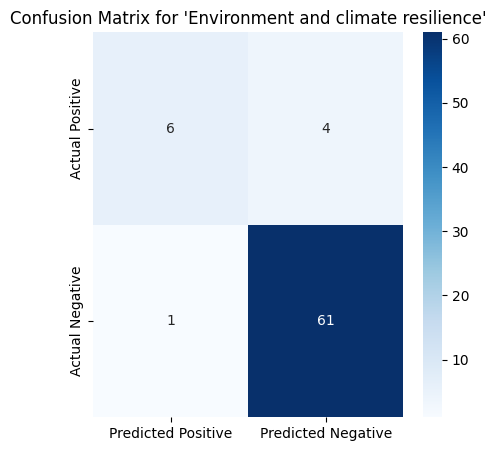

Accuracy: 0.8611111111111112
Precision: 0.6
Recall: 0.6923076923076923
F1 Score: 0.6428571428571429


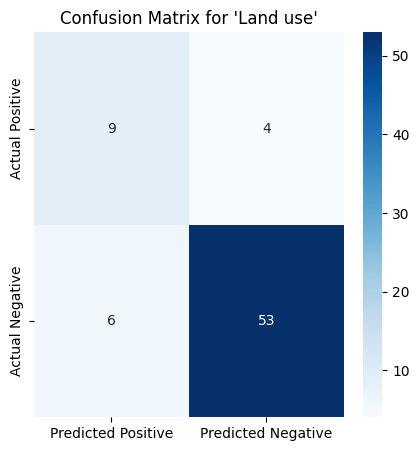

Accuracy: 0.9444444444444444
Precision: 0.6666666666666666
Recall: 0.8571428571428571
F1 Score: 0.75


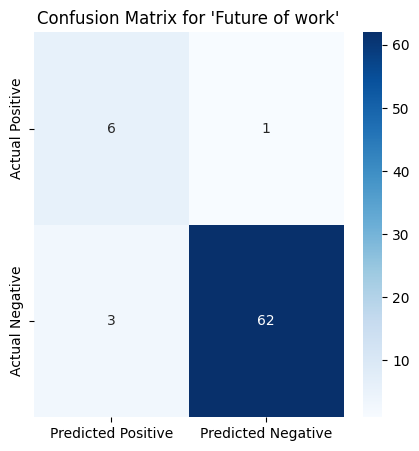

Accuracy: 0.9027777777777778
Precision: 0.6
Recall: 0.9
F1 Score: 0.7200000000000001


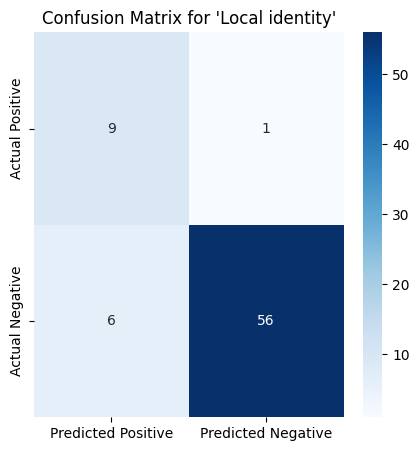

Accuracy: 0.9861111111111112
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8


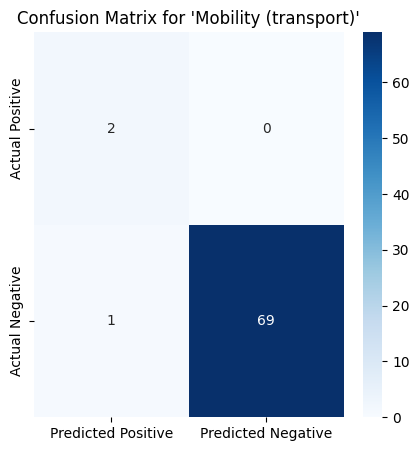

Accuracy: 0.7916666666666666
Precision: 0.8260869565217391
Recall: 0.6333333333333333
F1 Score: 0.7169811320754716


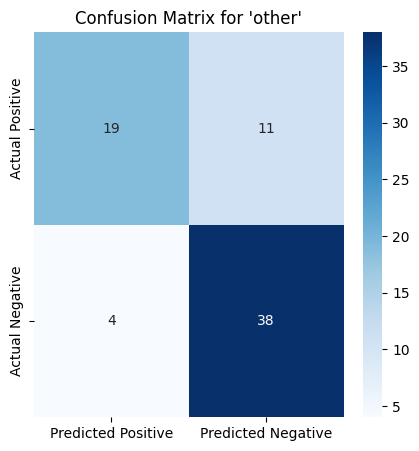

In [241]:
eval('Environment and climate resilience')
eval('Land use')
eval('Future of work')
eval('Local identity')
eval('Mobility (transport)')
eval('other')